In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

In [3]:
pio.renderers.default = 'browser'

In [ ]:
df_ple1 = pd.read_csv(r"../data/data-1767790355598.csv")
df_ple2 = pd.read_csv(r"../data/data-1767790491093.csv")

df_ple1['maquina'] = 'MAQ_1'
df_ple2['maquina'] = 'MAQ_2'



In [5]:
print(df_ple1.columns)
print(df_ple1.columns)


Index(['id', 'numero_serie', 'tension_r', 'corriente_r', 'potencia_a_r',
       'potencia_r_r', 'tension_s', 'corriente_s', 'potencia_a_s',
       'potencia_r_s', 'tension_t', 'corriente_t', 'potencia_a_t',
       'potencia_r_t', 'temporal_placa', 'temporal_server', 'update',
       'maquina'],
      dtype='object')
Index(['id', 'numero_serie', 'tension_r', 'corriente_r', 'potencia_a_r',
       'potencia_r_r', 'tension_s', 'corriente_s', 'potencia_a_s',
       'potencia_r_s', 'tension_t', 'corriente_t', 'potencia_a_t',
       'potencia_r_t', 'temporal_placa', 'temporal_server', 'update',
       'maquina'],
      dtype='object')


In [6]:
def preparar_df(df):
    df = df.copy()

    # Timestamp
    df['temporal_placa'] = pd.to_datetime(df['temporal_placa'])
    df['hora'] = df['temporal_placa'].dt.hour
    df['minuto'] = df['temporal_placa'].dt.minute

    # Turnos
    def asignar_turno(hora, minuto):
        t = hora * 60 + minuto

        # Pausas
        if 12*60 <= t < 12*60 + 30:
            return 'ALMUERZO'
        if 22*60 <= t < 22*60 + 30:
            return 'CENA'

        # Turnos
        if 5*60 <= t < 17*60:
            return 'TURNO MAÑANA'
        if 17*60 <= t < 22*60:
            return 'TURNO TARDE'
        if (t >= 22*60 + 30) or (t < 1*60):
            return 'TURNO TARDE'

        return 'FUERA_TURNO'

    df['turno'] = df.apply(
        lambda x: asignar_turno(x['hora'], x['minuto']),
        axis=1
    )
        
    # Potencias totales por timestamp
    df['p_activa_total'] = (
        df['potencia_a_r'] +
        df['potencia_a_s'] +
        df['potencia_a_t']
    )

    df['q_reactiva_total'] = (
        df['potencia_r_r'] +
        df['potencia_r_s'] +
        df['potencia_r_t']
    )

    return df


In [7]:
df_ple1 = preparar_df(df_ple1)
df_ple2 = preparar_df(df_ple2)
df_all = pd.concat([df_ple1, df_ple2], ignore_index=True)

In [8]:
# Calculos
eventos = [
    ['TURNO_MAÑANA', '05:00', '17:00'],
    ['ALMUERZO',     '12:00', '12:30'],
    ['TURNO_TARDE',  '17:00', '1:00'],
    ['CENA',  '10:00', '10:30']]

#df.groupby('turno')[tensiones].mean()   # Promedio de las tensiones por turno

#df.groupby('turno')[corrientes].mean()  # Promedio de las corrientes por turno

#df.groupby('turno')[['p_activa_total', 'p_reactiva_total']].mean()  # Promedio de las potencias por turno

#df['fp'] = df['p_activa_total'] / np.sqrt(
#    df['p_activa_total']**2 + df['p_reactiva_total']**2     # Calculo factor de potencia
#)

#df.groupby('turno')['fp'].mean()    # Promedio del factor de potencia por turno

turnos_interes = ['ALMUERZO', 'CENA', 'FUERA_TURNO']
df_pausas = df_all[df_all['turno'].isin(turnos_interes)]

resumen_corrientes = (
    df_all
    .loc[df_all['turno'].isin(turnos_interes)]
    .groupby(['turno','maquina'])[['corriente_r','corriente_s','corriente_t']]
    .mean()
)
resumen_corrientes

resumen_p = (
    df_all
    .loc[df_all['turno'].isin(turnos_interes)]
    .groupby(['turno','maquina'])['p_activa_total']
    .mean()
    .unstack('maquina')   # columnas = máquinas
    .loc[turnos_interes]  # orden lógico
)

resumen_q = (
    df_all
    .loc[df_all['turno'].isin(turnos_interes)]
    .groupby(['turno','maquina'])['q_reactiva_total']
    .mean()
    .unstack('maquina')
    .loc[turnos_interes]
)

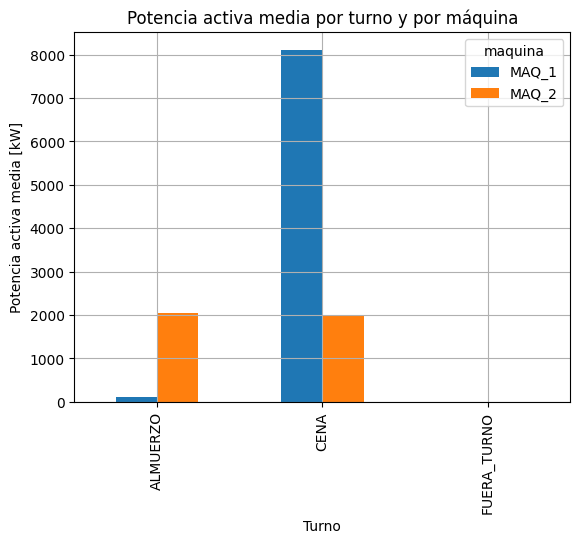

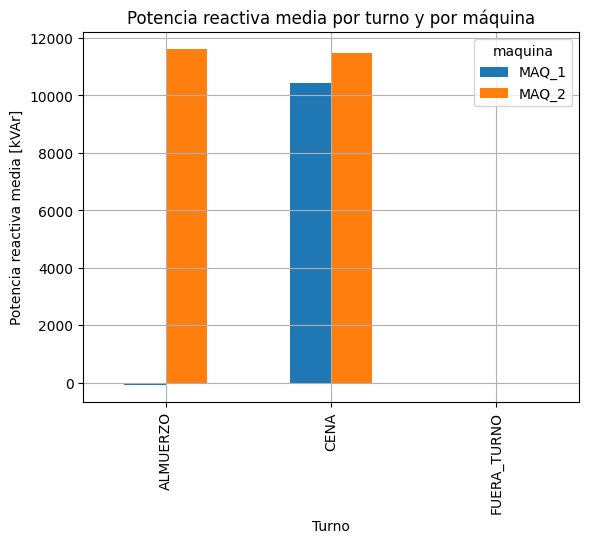

In [15]:
# Visualizacion
import plotly.graph_objects as go

fig = go.Figure()

#---------------------------- CORRIENTES ----------------------------#
fases = {
    'Fase R': 'corriente_r',
    'Fase S': 'corriente_s',
    'Fase T': 'corriente_t'
}

maquinas = resumen_corrientes.index.get_level_values('maquina').unique()

for fase_label, fase_col in fases.items():
    for maq in maquinas:
        valores = (
            resumen_corrientes[fase_col]
            .xs(maq, level='maquina')
            .reindex(turnos_interes)
        )

        fig.add_trace(
            go.Bar(
                x=turnos_interes,
                y=valores,
                name=str(maq),
                visible=(fase_label == 'Fase R')  # Fase R visible por defecto
            )
        )

# Dropdown
buttons = []
n_maquinas = len(maquinas)

for i, fase_label in enumerate(fases.keys()):
    visible = [False] * len(fig.data)
    for j in range(n_maquinas):
        visible[i*n_maquinas + j] = True

    buttons.append(
        dict(
            label=fase_label,
            method='update',
            args=[
                {'visible': visible},
                {
                    'title': {
                    'text': f'Corriente media por turno – {fase_label}',
                    'x': 0.5,
                    'xanchor': 'center',
                    'font': {'size': 18}
                    }
                }
            ]
        )
    )

fig.update_layout(
    title=dict(
        text='Corriente Media – Fase R',
        x=0.5,
        xanchor='center',
        font=dict(size=18)
      ),
    yaxis_title='Corriente media [A]',
    xaxis_title='Turno',
    barmode='group',
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.01,
            y=1.15
        )
    ]
)

#----------------------------POTENCIA P----------------------------# 
resumen_p.plot( 
    kind='bar', 
    ylabel='Potencia activa media [kW]', 
    title='Potencia activa media por turno y por máquina', 
    grid=True 
) 
plt.xlabel('Turno')
#----------------------------POTENCIA Q----------------------------# 
resumen_q.plot( 
    kind='bar', 
    ylabel='Potencia reactiva media [kVAr]', 
    title='Potencia reactiva media por turno y por máquina', 
    grid=True ) 
plt.xlabel('Turno')
fig.show()